In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.arima.model import ARIMA
from cycler import cycler

%matplotlib inline

# Set color cycle for all plots
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[plt.get_cmap("Set2")(i) for i in range(9)]
)

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)

In [2]:
# Set the file path here, and "Run All"
datasets_file_path = "../clusters/cluster_3.csv"

df_tmp = pd.read_csv(datasets_file_path)
customers = df_tmp["customer_unique_id"]

In [3]:
# read dataframe
df_customers = pd.read_csv('../datasets/olist_customers_dataset.csv')
df_order_payments = pd.read_csv("../datasets/olist_order_payments_dataset.csv")
df_orders = pd.read_csv('../datasets/olist_orders_dataset.csv')

# merge dataframes
orders = pd.merge(
    df_customers[['customer_id', 'customer_unique_id']],
    df_orders[['order_id', 'customer_id', 'order_purchase_timestamp']],
    on='customer_id'
)
orders = pd.merge(
    orders,
    df_order_payments[['order_id', 'payment_value']],
    on='order_id'
)
orders.drop('customer_id', axis=1, inplace=True)
print(f"orders.shape: {orders.shape}")
print(f"orders.columns: {orders.columns}")

orders.shape: (103886, 4)
orders.columns: Index(['customer_unique_id', 'order_id', 'order_purchase_timestamp',
       'payment_value'],
      dtype='object')


In [4]:
# filter orders by date between 2017-01-01 and 2018-07-31
orders['order_purchase_timestamp'] = pd.to_datetime(
  orders['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S'
)
orders = orders[
    (orders['order_purchase_timestamp'] >= '2017-01-01') &
    (orders['order_purchase_timestamp'] <= '2018-07-31')
]

# filter orders by the input customer_unique_id
df = orders[orders['customer_unique_id'].isin(customers)]
print(f"df.shape: {df.shape}")

df.shape: (3508, 4)


In [5]:
def plot_sales_with_forecast_and_moving_average(df, title, future_days):
    df_daily = df.resample("D", on="order_purchase_timestamp").sum()["payment_value"]
    moving_average = df_daily.rolling(window=7).mean()
    df_daily = df_daily.reset_index()
    df_daily["days_since_start"] = (df_daily["order_purchase_timestamp"] - df_daily["order_purchase_timestamp"].min()).dt.days

    # Train a linear regression model
    X = df_daily[["days_since_start"]]
    y = df_daily["payment_value"]
    model = LinearRegression()
    model.fit(X, y)

    # Predict future sales
    last_day = df_daily["days_since_start"].iloc[-1]
    future_dates = np.arange(last_day + 1, last_day + future_days + 1)
    future_dates = future_dates.reshape(-1, 1)
    future_sales = model.predict(future_dates)

    plt.figure(figsize=(15, 6))
    plt.plot(df_daily["order_purchase_timestamp"], y, label="Actual Sales")
    plt.plot(df_daily["order_purchase_timestamp"], moving_average, label="7-day Moving Average", linestyle="-", linewidth=1)
    future_dates_in_datetime = pd.date_range(
        start=df_daily["order_purchase_timestamp"].iloc[-1] + pd.Timedelta(days=1), periods=future_days
    )
    plt.plot(future_dates_in_datetime, future_sales, label="Predicted Sales", linestyle="--", linewidth=2)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()

In [6]:
def calculate_moving_average(df_daily):
    return df_daily.rolling(window=7).mean()

def linear_regression_forecast(df_daily, future_days):
    df_lr = df_daily.reset_index()
    df_lr["days_since_start"] = (df_lr["order_purchase_timestamp"] - df_lr["order_purchase_timestamp"].min()).dt.days
    X = df_lr[["days_since_start"]]
    y = df_lr["payment_value"]
    model = LinearRegression().fit(X, y)
    last_day = X["days_since_start"].iloc[-1]
    future_dates = pd.DataFrame(np.arange(last_day + 1, last_day + future_days + 1), columns=["days_since_start"])  # 特徴名を含むDataFrameを作成
    future_sales, future_dates_in_datetime = model.predict(future_dates), pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1), periods=future_days)
    return future_sales, future_dates_in_datetime

def polynomial_regression_forecast(df_daily, future_days):
    df_poly = df_daily.reset_index()
    df_poly["days_since_start"] = (df_poly["order_purchase_timestamp"] - df_poly["order_purchase_timestamp"].min()).dt.days
    X = df_poly[["days_since_start"]]
    y = df_poly["payment_value"]
    poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    poly_model.fit(X, y)
    last_day = X.iloc[-1, 0]
    future_dates = pd.DataFrame(np.arange(last_day + 1, last_day + future_days + 1), columns=["days_since_start"])
    future_sales_poly = poly_model.predict(future_dates)
    future_dates_in_datetime = pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1), periods=future_days)
    return future_sales_poly, future_dates_in_datetime

def arima_forecast(df_daily, future_days):
    model = ARIMA(df_daily, order=(5,1,0)).fit()
    return model.forecast(steps=future_days), pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1), periods=future_days)

def plot_forecasts(df_daily, moving_average, future_sales_lr, future_dates_lr, future_sales_poly, future_dates_poly, future_sales_arima, future_dates_arima, title):
    plt.figure(figsize=(15, 3))
    plt.plot(df_daily.index, df_daily, label="Actual Sales")
    plt.plot(df_daily.index, moving_average, label="7-day Moving Average", linestyle="-", linewidth=1)
    # plt.plot(future_dates_lr, future_sales_lr, label="Linear Regression Forecast", linestyle="--", linewidth=3)
    # plt.plot(future_dates_poly, future_sales_poly, label="Polynomial Regression Forecast", linestyle="--", linewidth=3)
    # plt.plot(future_dates_arima, future_sales_arima, label="ARIMA Forecast", linestyle=":", linewidth=3)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()

def plot_sales_with_forecast_and_moving_average(df, title, future_days):
    df_daily = df.set_index("order_purchase_timestamp").resample("D").sum()["payment_value"]
    moving_average = calculate_moving_average(df_daily)
    # Future sales forecast
    future_sales_lr, future_dates_lr = linear_regression_forecast(df_daily, future_days)
    future_sales_poly, future_dates_poly = polynomial_regression_forecast(df_daily, future_days)
    future_sales_arima, future_dates_arima = arima_forecast(df_daily, future_days)
    # Plots
    plot_forecasts(
        df_daily, moving_average,
        future_sales_lr, future_dates_lr,
        future_sales_poly, future_dates_poly,
        future_sales_arima, future_dates_arima,
        title
    )

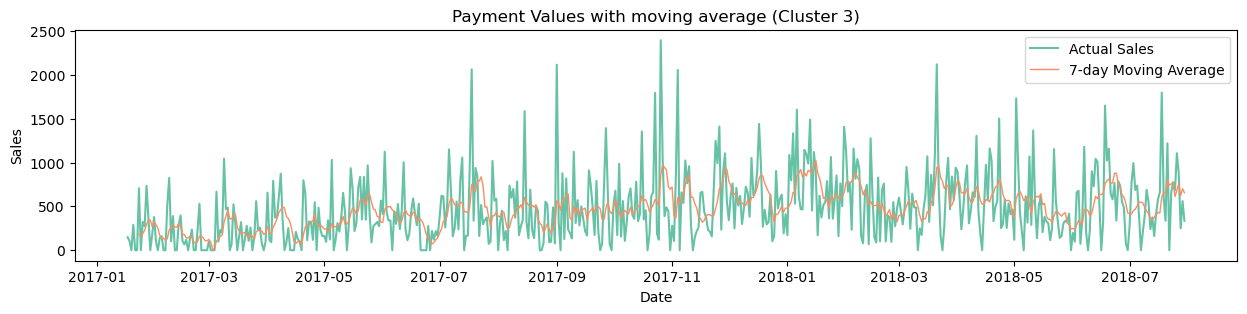

In [7]:
plot_sales_with_forecast_and_moving_average(
    df,
    "Payment Values with moving average (Cluster 3)",
    120
)

## Cross Validation: Walk Forward Validation

**Walk Forward Validation**

- Simulates making predictions on a rolling basis
- Uses training and test sets, with a rolling window approach
- Evaluates model performance on unseen future data

**Characteristics**
- Time series split into training and test sets
- Training set divided into rolling windows
- Model trained on window, tested on next window (out-of-sample)

**Strengths**
- Realistic evaluation of model performance
- Accounts for time-varying data characteristics
- Reveals potential weaknesses or instabilities

**Weaknesses**
- Computationally expensive
- Data scarcity can impact training
- Parameter sensitivity (window and step size)

**Comments**
- Useful for time-series/streaming data predictions
- More realistic than traditional evaluation methods
- Requires careful parameter tuning
- Training/test data should represent real-world scenarios

/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_77968/936554868.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'year'] = df['order_purchase_timestamp'].dt.year
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_77968/936554868.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'month'] = df['order_purchase_timestamp'].dt.month
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_77968/936554868.py:10: SettingWithCopyWarning: 
A value is trying to be set on 

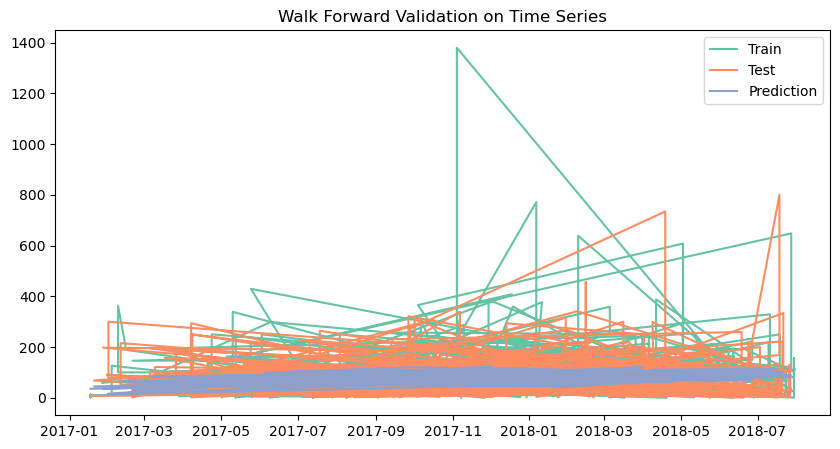

/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_77968/936554868.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'year'] = df['order_purchase_timestamp'].dt.year
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_77968/936554868.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'month'] = df['order_purchase_timestamp'].dt.month
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_77968/936554868.py:10: SettingWithCopyWarning: 
A value is trying to be set on 

RMSE: 83.69014590605009


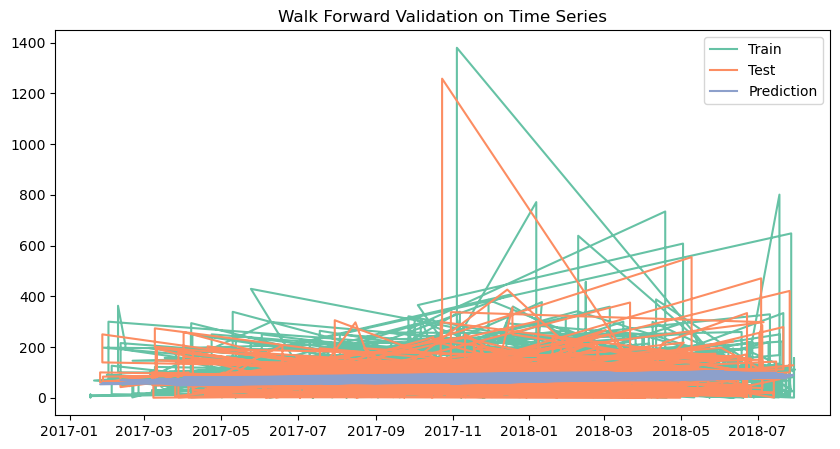

RMSE: 90.74348692251033


/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_77968/936554868.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'year'] = df['order_purchase_timestamp'].dt.year
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_77968/936554868.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'month'] = df['order_purchase_timestamp'].dt.month
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_77968/936554868.py:10: SettingWithCopyWarning: 
A value is trying to be set on 

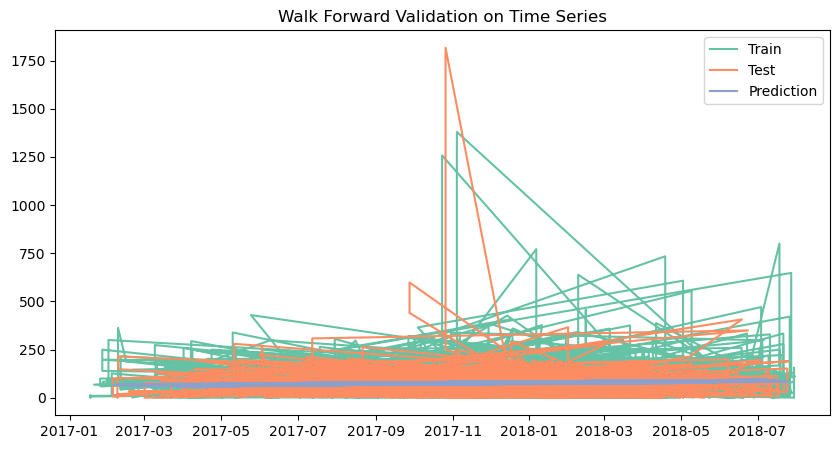

RMSE: 100.6577696772588


/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_77968/936554868.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'year'] = df['order_purchase_timestamp'].dt.year
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_77968/936554868.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'month'] = df['order_purchase_timestamp'].dt.month
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_77968/936554868.py:10: SettingWithCopyWarning: 
A value is trying to be set on 

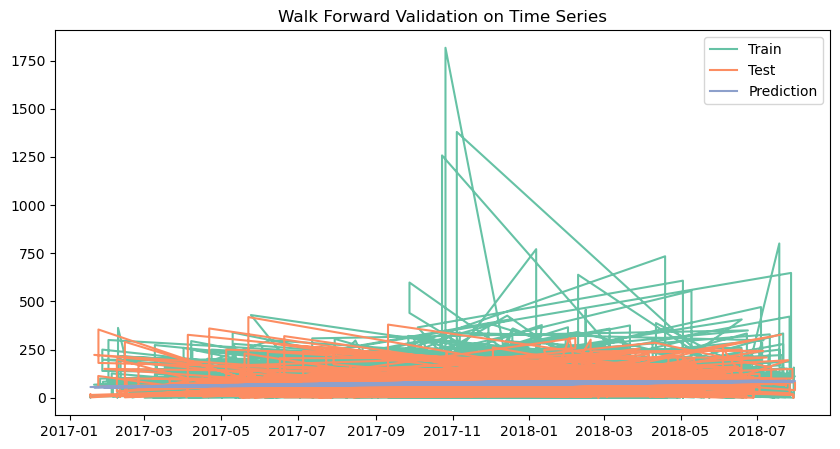

RMSE: 70.86349600207436


/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_77968/936554868.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'year'] = df['order_purchase_timestamp'].dt.year
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_77968/936554868.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'month'] = df['order_purchase_timestamp'].dt.month
/var/folders/9r/bsd76cw537n872tfj2lhrmfc0000gn/T/ipykernel_77968/936554868.py:10: SettingWithCopyWarning: 
A value is trying to be set on 

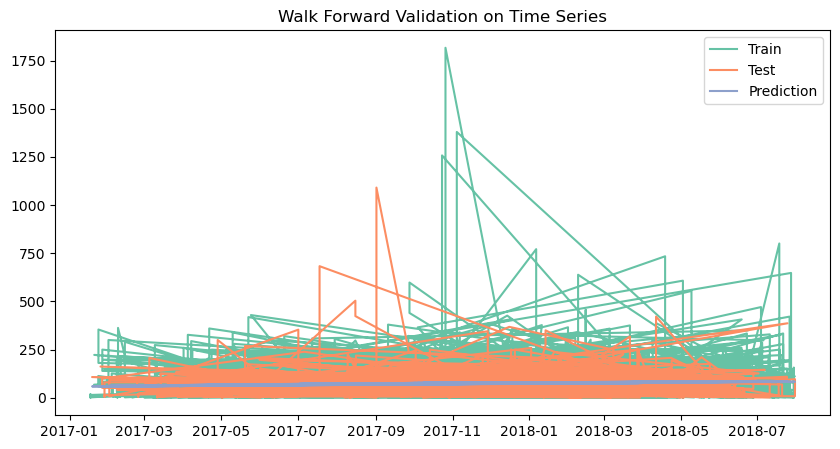

RMSE: 86.88630167004727


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def create_features(df):
    df.loc[:, 'year'] = df['order_purchase_timestamp'].dt.year
    df.loc[:, 'month'] = df['order_purchase_timestamp'].dt.month
    df.loc[:, 'day'] = df['order_purchase_timestamp'].dt.day
    df.loc[:, 'dayofweek'] = df['order_purchase_timestamp'].dt.dayofweek

    return df

# Walk Forward Validation 関数
def walk_forward_validation(data, n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for train_index, test_index in tscv.split(data):
        train, test = data.iloc[train_index, :], data.iloc[test_index, :]

        train = create_features(train)
        test = create_features(test)

        X_train, y_train = train.drop(['order_purchase_timestamp', 'payment_value'], axis=1), train['payment_value']
        X_test, y_test = test.drop(['order_purchase_timestamp', 'payment_value'], axis=1), test['payment_value']

        model = LinearRegression()
        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        plt.figure(figsize=(10, 5))
        plt.plot(train['order_purchase_timestamp'], y_train, label='Train')
        plt.plot(test['order_purchase_timestamp'], y_test, label='Test')
        plt.plot(test['order_purchase_timestamp'], predictions, label='Prediction')
        plt.legend()
        plt.title('Walk Forward Validation on Time Series')
        plt.show()

        mse = np.mean((y_test - predictions)**2)
        rmse = np.sqrt(mse)
        print(f"RMSE: {rmse}")


df = df[["order_purchase_timestamp", "payment_value"]]
walk_forward_validation(df, n_splits=5)


  order_purchase_timestamp  payment_value  days_since_start
0               2017-01-17      15.009412                 0
1               2017-01-20     145.255000                 3
2               2017-01-23     146.965714                 6
3               2017-01-26      66.090000                 9
4               2017-01-29     139.357500                12


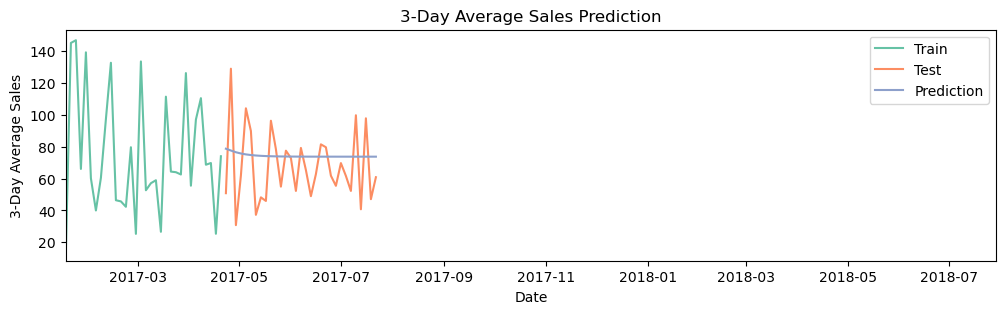

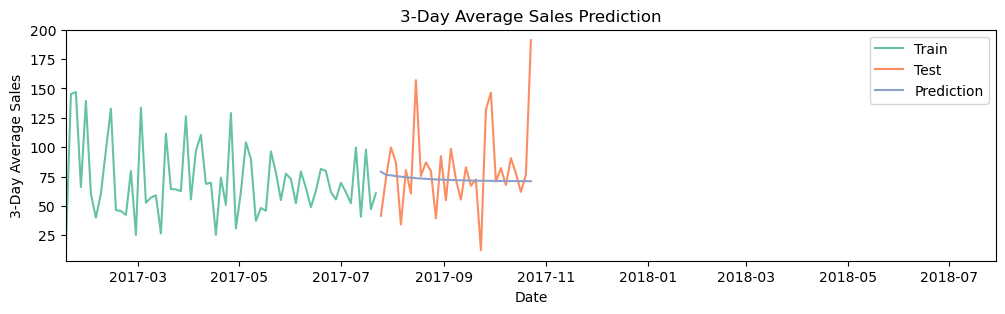

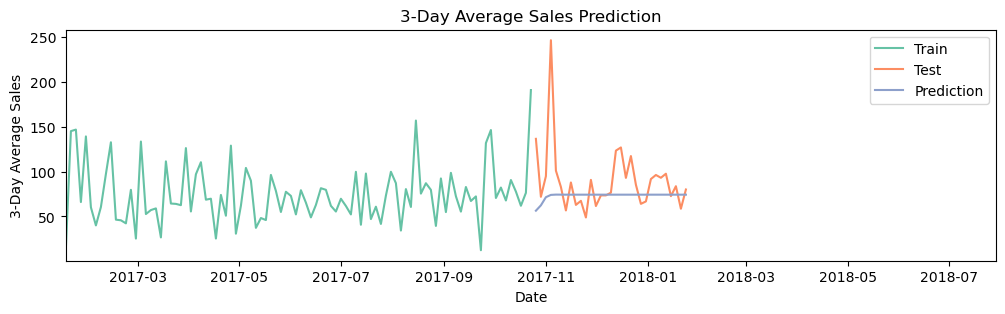

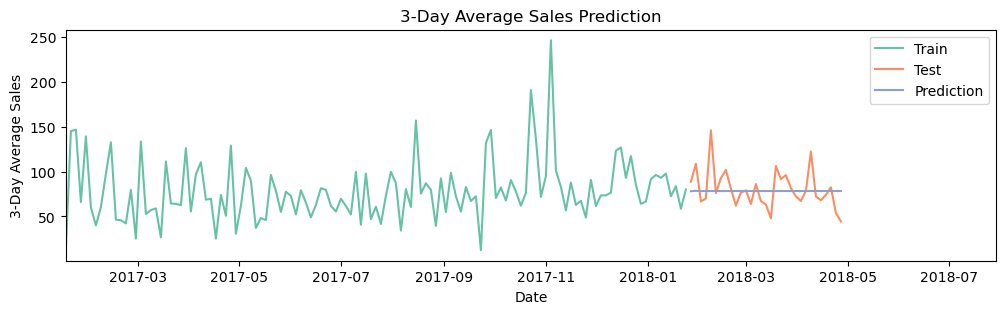

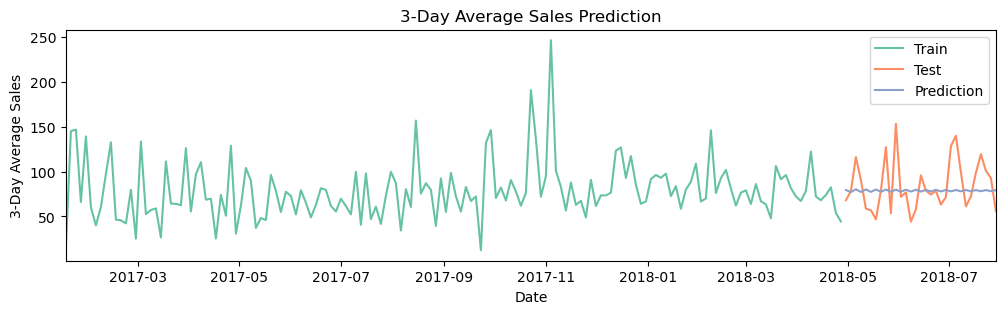

,MAE,MSE,RMSE,R2
0,19.376551,524.969561,22.912214,-0.087236
1,24.002039,1355.067245,36.811238,-0.082539
2,23.752873,1587.591488,39.844592,-0.265850
3,15.371410,443.278114,21.054171,-0.008448
4,21.626492,788.512106,28.080458,-0.028115


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm

df = df.sort_values('order_purchase_timestamp')


df.set_index('order_purchase_timestamp', inplace=True)

df_resampled = df['payment_value'].resample('3D').mean()
df_resampled.fillna(df_resampled.mean(), inplace=True)


df_resampled = df_resampled.reset_index()
df_resampled['days_since_start'] = (df_resampled['order_purchase_timestamp'] - df_resampled['order_purchase_timestamp'].min()).dt.days

print(df_resampled.head())
X = df_resampled[['days_since_start']]
y = df_resampled['payment_value']
tscv = TimeSeriesSplit(n_splits=5)

min_date = df_resampled['order_purchase_timestamp'].min()
max_date = df_resampled['order_purchase_timestamp'].max()


scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # # Linear Regression
    # model = LinearRegression()
    # model.fit(X_train, y_train)
    # predictions = model.predict(X_test)

    # # Polynomial Regression
    # degree = 2
    # model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    # model.fit(X_train, y_train)
    # predictions = model.predict(X_test)

    # ARIMA
    n_forecast = len(X_test)
    order = (2, 0, 1)  # (p, d, q)
    model = sm.tsa.ARIMA(y_train, order=order)
    arima_result = model.fit()
    predictions = arima_result.get_forecast(steps=n_forecast).predicted_mean


    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)

    scores.append({
        'MAE': mean_absolute_error(y_test, predictions),
        'MSE': mean_squared_error(y_test, predictions),
        'RMSE': mean_squared_error(y_test, predictions, squared=False),
        'R2': r2_score(y_test, predictions)
    })

    plt.figure(figsize=(12, 3))
    plt.plot(df_resampled['order_purchase_timestamp'].iloc[train_index], y_train, label='Train')
    plt.plot(df_resampled['order_purchase_timestamp'].iloc[test_index], y_test, label='Test')
    plt.plot(df_resampled['order_purchase_timestamp'].iloc[test_index], predictions, label='Prediction')
    plt.xlim(min_date, max_date)
    plt.legend(loc='upper right')
    plt.title('3-Day Average Sales Prediction')
    plt.xlabel('Date')
    plt.ylabel('3-Day Average Sales')
    plt.show()

scores_df = pd.DataFrame(scores)
scores_df


In [10]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_score, best_cfg = float("inf"), None

# Grid search
for param in pdq:
    try:
        for train_index, test_index in TimeSeriesSplit(n_splits=5).split(y):
            train, test = y.iloc[train_index], y.iloc[test_index]
            model = ARIMA(train, order=param)
            model_fit = model.fit()
            predictions = model_fit.forecast(steps=len(test))
            score = mean_squared_error(test, predictions)
            if score < best_score:
                best_score, best_cfg = score, param
            print('ARIMA%s MSE=%.3f' % (param, score))
    except:
        continue

print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))


ARIMA(0, 0, 0) MSE=538.348
ARIMA(0, 0, 0) MSE=1350.724
ARIMA(0, 0, 0) MSE=1484.601
ARIMA(0, 0, 0) MSE=443.119
ARIMA(0, 0, 0) MSE=796.714
ARIMA(0, 0, 1) MSE=544.393
ARIMA(0, 0, 1) MSE=1353.243
ARIMA(0, 0, 1) MSE=1581.204
ARIMA(0, 0, 1) MSE=443.085
ARIMA(0, 0, 1) MSE=795.981
ARIMA(0, 0, 2) MSE=551.885
ARIMA(0, 0, 2) MSE=1357.753
ARIMA(0, 0, 2) MSE=1584.788
ARIMA(0, 0, 2) MSE=443.016
ARIMA(0, 0, 2) MSE=796.179
ARIMA(0, 1, 0) MSE=524.299
ARIMA(0, 1, 0) MSE=1670.290
ARIMA(0, 1, 0) MSE=11503.924
ARIMA(0, 1, 0) MSE=439.620
ARIMA(0, 1, 0) MSE=2355.507
ARIMA(0, 1, 1) MSE=538.276
ARIMA(0, 1, 1) MSE=1354.762
ARIMA(0, 1, 1) MSE=1483.293
ARIMA(0, 1, 1) MSE=467.355
ARIMA(0, 1, 1) MSE=789.683
ARIMA(0, 1, 2) MSE=542.296
ARIMA(0, 1, 2) MSE=1420.995
ARIMA(0, 1, 2) MSE=1415.339
ARIMA(0, 1, 2) MSE=467.076
ARIMA(0, 1, 2) MSE=788.438
ARIMA(0, 2, 0) MSE=809342.131
ARIMA(0, 2, 0) MSE=54681.459
ARIMA(0, 2, 0) MSE=4822646.203
ARIMA(0, 2, 0) MSE=157844.787
ARIMA(0, 2, 0) MSE=45499.324
ARIMA(0, 2, 1) MSE=2199.303

### Create bar chart

In [11]:
# read dataframe
df_customers = pd.read_csv('../datasets/olist_customers_dataset.csv')
df_order_payments = pd.read_csv("../datasets/olist_order_payments_dataset.csv")
df_orders = pd.read_csv('../datasets/olist_orders_dataset.csv')
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])

def get_payment_values(datasets_file_path):
    df_tmp = pd.read_csv(datasets_file_path)
    customers = df_tmp["customer_unique_id"]
    df_customers_filtered = df_customers[df_customers['customer_unique_id'].isin(customers)]

    # merge dataframes
    orders = pd.merge(
        df_customers_filtered[['customer_id', 'customer_unique_id']],
        df_orders[['order_id', 'customer_id', 'order_purchase_timestamp']],
        on='customer_id'
    )
    orders = pd.merge(
        orders,
        df_order_payments[['order_id', 'payment_value']],
        on='order_id'
    )
    payment_values = orders[['order_purchase_timestamp', 'payment_value']]

    return payment_values

df1 = get_payment_values("../clusters/cluster_1.csv")
df2 = get_payment_values("../clusters/cluster_2.csv")
df3 = get_payment_values("../clusters/cluster_3.csv")

print(df1.shape, df2.shape, df3.shape)

(96185, 2) (156, 2) (3700, 2)


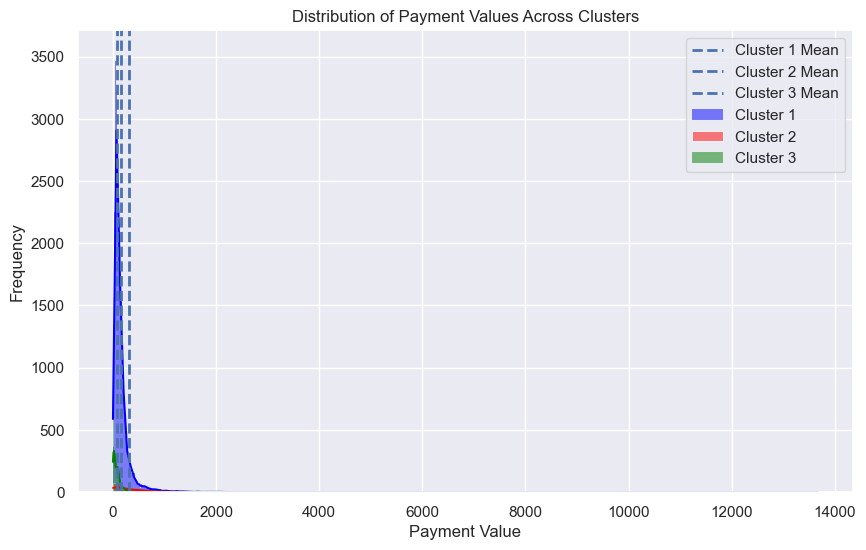

In [12]:
import seaborn as sns

mean1 = df1['payment_value'].mean()
mean2 = df2['payment_value'].mean()
mean3 = df3['payment_value'].mean()

cluster_means = pd.DataFrame({
    'Cluster': ['Cluster 1', 'Cluster 2', 'Cluster 3'],
    'Mean Payment Value': [mean1, mean2, mean3]
})

means = [mean1, mean2, mean3]

sns.set()
plt.figure(figsize=(10, 6))

sns.histplot(df1['payment_value'], color="blue", label="Cluster 1", kde=True)
sns.histplot(df2['payment_value'], color="red", label="Cluster 2", kde=True)
sns.histplot(df3['payment_value'], color="green", label="Cluster 3", kde=True)

for i, mean in enumerate(means):
    plt.axvline(mean, linestyle='--', linewidth=2, label=f'Cluster {i+1} Mean')

plt.title('Distribution of Payment Values Across Clusters')
plt.xlabel('Payment Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [13]:
cluster_means

,Cluster,Mean Payment Value
0,Cluster 1,155.547252
1,Cluster 2,316.682885
2,Cluster 3,76.405200


  order_purchase_timestamp  payment_value  days_since_start
0               2017-01-17      15.009412                 0
1               2017-01-20     145.255000                 3
2               2017-01-23     146.965714                 6
3               2017-01-26      66.090000                 9
4               2017-01-29     139.357500                12


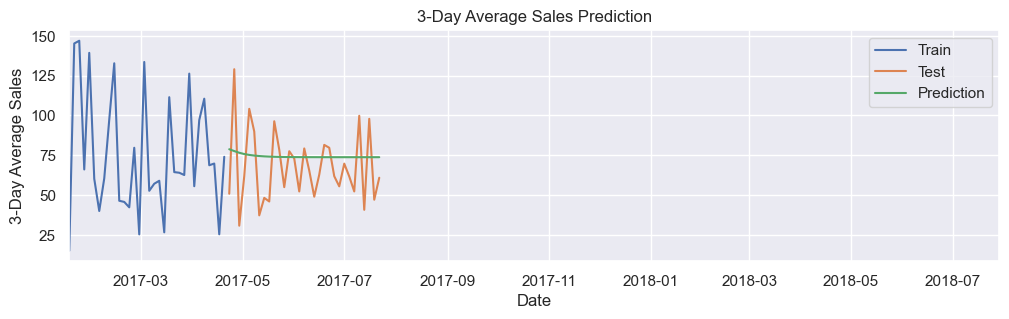

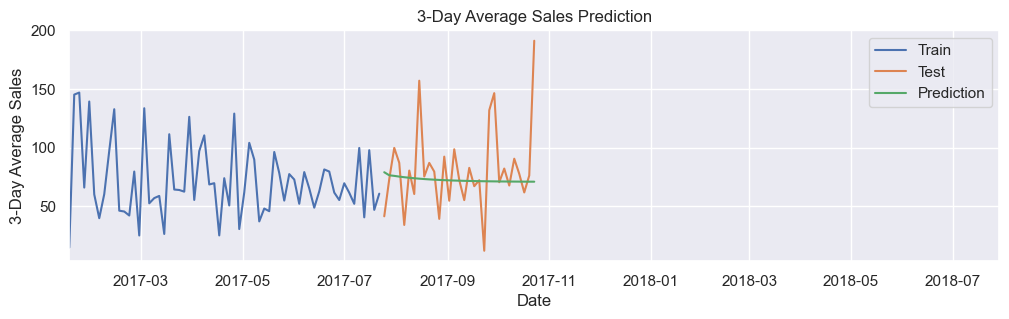

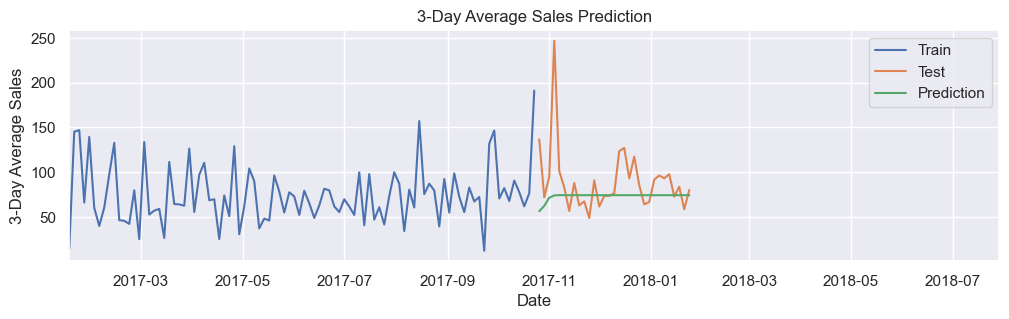

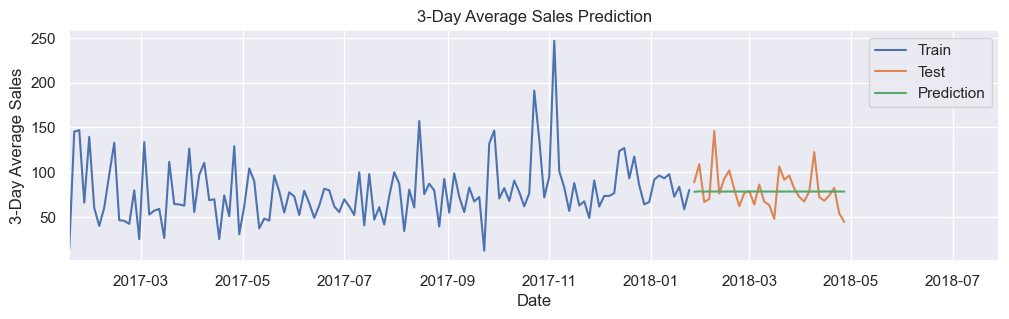

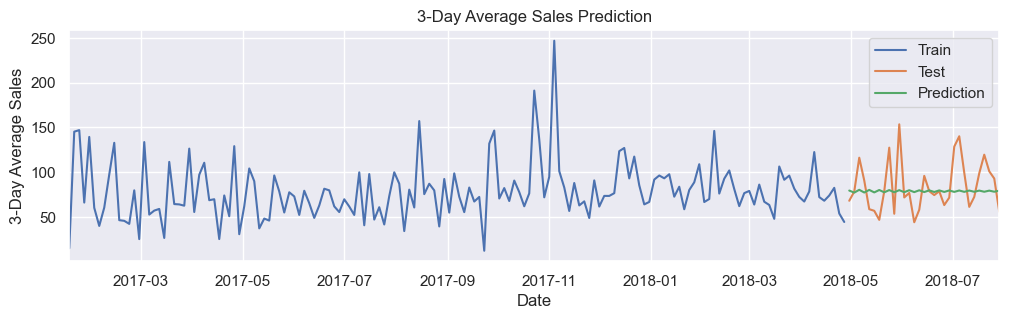

,MAE,MSE,RMSE,R2
0,19.376551,524.969561,22.912214,-0.087236
1,24.002389,1355.091277,36.811564,-0.082558
2,23.752873,1587.591488,39.844592,-0.265850
3,15.371410,443.278113,21.054171,-0.008448
4,21.626781,788.486283,28.079998,-0.028081


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm

df = df.sort_values('order_purchase_timestamp')


# df.set_index('order_purchase_timestamp', inplace=True)

df_resampled = df['payment_value'].resample('3D').mean()
df_resampled.fillna(df_resampled.mean(), inplace=True)


df_resampled = df_resampled.reset_index()
df_resampled['days_since_start'] = (df_resampled['order_purchase_timestamp'] - df_resampled['order_purchase_timestamp'].min()).dt.days

print(df_resampled.head())
X = df_resampled[['days_since_start']]
y = df_resampled['payment_value']
tscv = TimeSeriesSplit(n_splits=5)

min_date = df_resampled['order_purchase_timestamp'].min()
max_date = df_resampled['order_purchase_timestamp'].max()


scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # # Linear Regression
    # model = LinearRegression()
    # model.fit(X_train, y_train)
    # predictions = model.predict(X_test)

    # # Polynomial Regression
    # degree = 2
    # model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    # model.fit(X_train, y_train)
    # predictions = model.predict(X_test)

    # ARIMA
    n_forecast = len(X_test)
    order = (2, 0, 1)  # (p, d, q)
    model = sm.tsa.ARIMA(y_train, order=order)
    arima_result = model.fit()
    predictions = arima_result.get_forecast(steps=n_forecast).predicted_mean


    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)

    scores.append({
        'MAE': mean_absolute_error(y_test, predictions),
        'MSE': mean_squared_error(y_test, predictions),
        'RMSE': mean_squared_error(y_test, predictions, squared=False),
        'R2': r2_score(y_test, predictions)
    })

    plt.figure(figsize=(12, 3))
    plt.plot(df_resampled['order_purchase_timestamp'].iloc[train_index], y_train, label='Train')
    plt.plot(df_resampled['order_purchase_timestamp'].iloc[test_index], y_test, label='Test')
    plt.plot(df_resampled['order_purchase_timestamp'].iloc[test_index], predictions, label='Prediction')
    plt.xlim(min_date, max_date)
    plt.legend(loc='upper right')
    plt.title('3-Day Average Sales Prediction')
    plt.xlabel('Date')
    plt.ylabel('3-Day Average Sales')
    plt.show()

scores_df = pd.DataFrame(scores)
scores_df


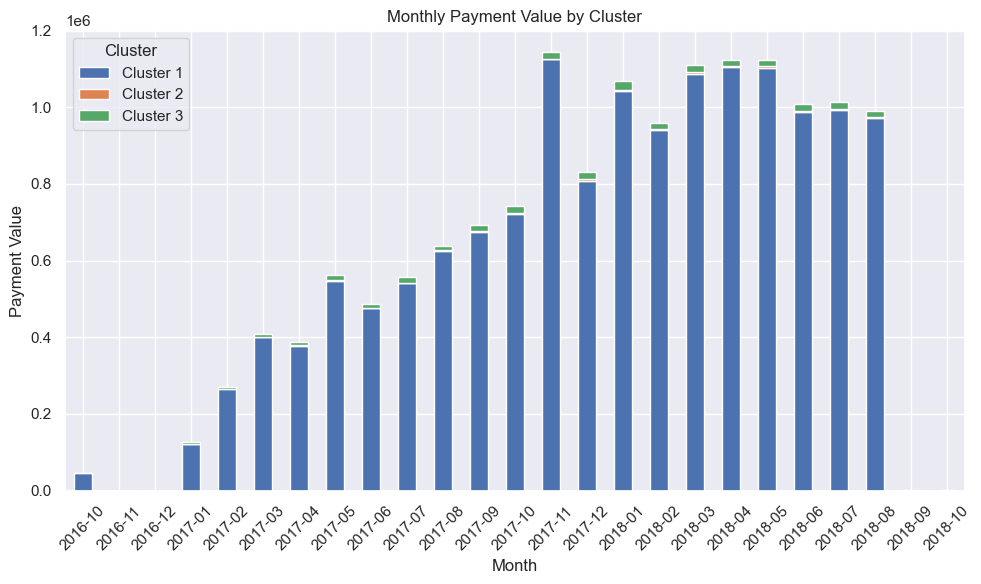

In [15]:
df1_monthly = df1.resample('M', on='order_purchase_timestamp').payment_value.sum()
df2_monthly = df2.resample('M', on='order_purchase_timestamp').payment_value.sum()
df3_monthly = df3.resample('M', on='order_purchase_timestamp').payment_value.sum()

df_monthly = pd.DataFrame({
    'Cluster 1': df1_monthly,
    'Cluster 2': df2_monthly,
    'Cluster 3': df3_monthly
})

df_monthly.fillna(0, inplace=True)

ax = df_monthly.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Monthly Payment Value by Cluster')
plt.xlabel('Month')
plt.ylabel('Payment Value')
plt.legend(title='Cluster')
ax.set_xticklabels([date.strftime('%Y-%m') for date in df_monthly.index])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


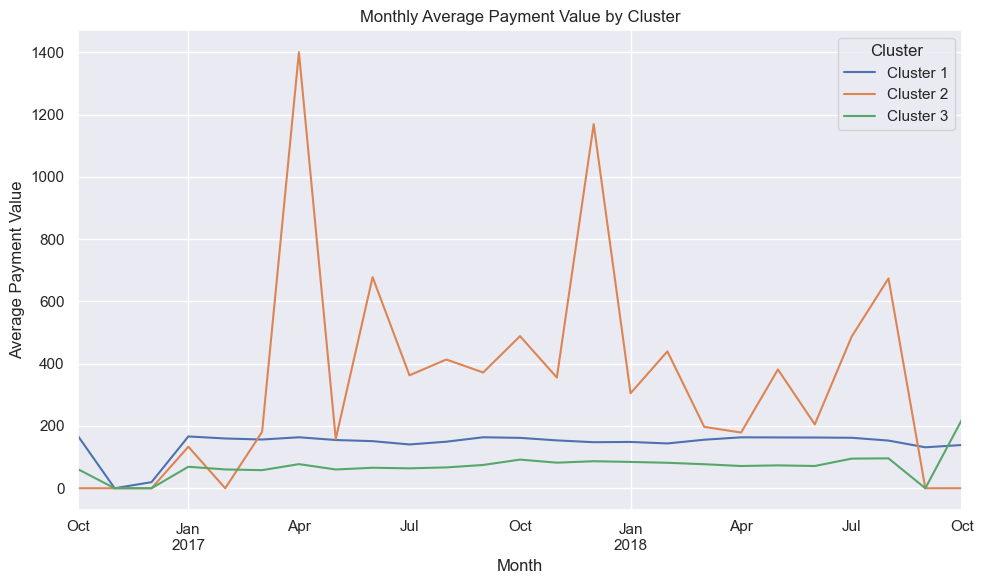

In [16]:
df1_monthly = df1.resample('M', on='order_purchase_timestamp').payment_value.mean()
df2_monthly = df2.resample('M', on='order_purchase_timestamp').payment_value.mean()
df3_monthly = df3.resample('M', on='order_purchase_timestamp').payment_value.mean()

df_monthly = pd.DataFrame({
    'Cluster 1': df1_monthly,
    'Cluster 2': df2_monthly,
    'Cluster 3': df3_monthly
})

df_monthly.fillna(0, inplace=True)

ax = df_monthly.plot(kind='line', figsize=(10, 6))
plt.title('Monthly Average Payment Value by Cluster')
plt.xlabel('Month')
plt.ylabel('Average Payment Value')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

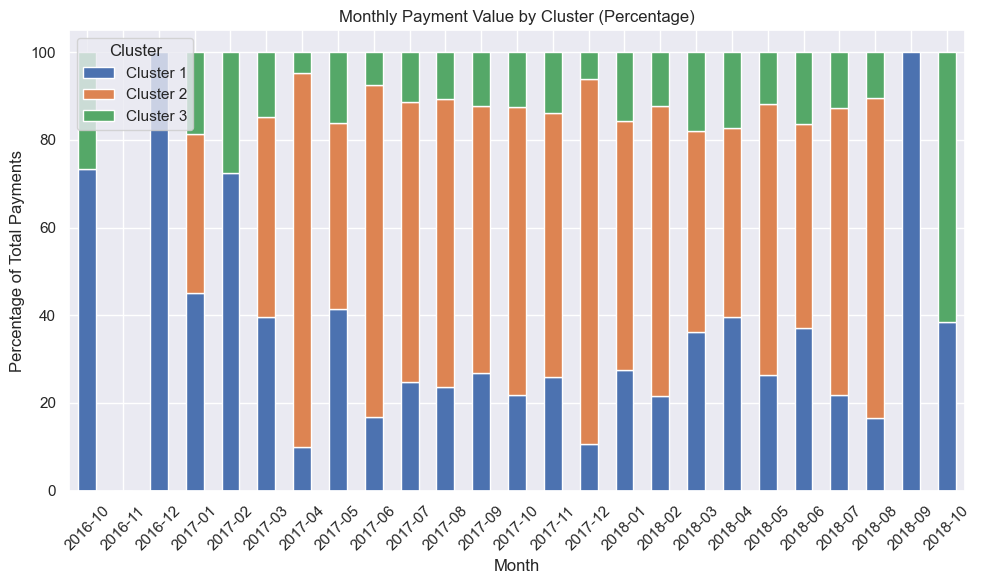

In [17]:
df_monthly_percent = df_monthly.div(df_monthly.sum(axis=1), axis=0) * 100

ax = df_monthly_percent.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_title('Monthly Payment Value by Cluster (Percentage)')
ax.set_xlabel('Month')
ax.set_ylabel('Percentage of Total Payments')
ax.legend(title='Cluster')

ax.set_xticklabels([date.strftime('%Y-%m') for date in df_monthly_percent.index])

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
df_monthly_percent

,Cluster 1,Cluster 2,Cluster 3
order_purchase_timestamp,,,
2016-10-31,73.275527,0.000000,26.724473
2016-11-30,NaN,NaN,NaN
2016-12-31,100.000000,0.000000,0.000000
2017-01-31,45.117105,36.164826,18.718069
2017-02-28,72.560458,0.000000,27.439542
2017-03-31,39.571758,45.739989,14.688252
2017-04-30,9.972333,85.308936,4.718731
2017-05-31,41.477088,42.394726,16.128186
2017-06-30,16.897055,75.749660,7.353286


In [19]:
df_cluster1 = pd.read_csv("../clusters/cluster_1.csv")
df_cluster2 = pd.read_csv("../clusters/cluster_2.csv")
df_cluster3 = pd.read_csv("../clusters/cluster_3.csv")

## For each cluster, get the number of 'repeater' == 1 and the percentaage.
def get_repeater_percentage(df):
    total = len(df)
    repeater = len(df[df['repeater'] == 1])
    return {'total_count': total, 'count': int(repeater), 'percentage': repeater / total * 100}

repeater_percentage = {
    'Cluster 1': get_repeater_percentage(df_cluster1),
    'Cluster 2': get_repeater_percentage(df_cluster2),
    'Cluster 3': get_repeater_percentage(df_cluster3)
}

df_repeater_percentage = pd.DataFrame(repeater_percentage).T
df_repeater_percentage['count'] = df_repeater_percentage['count'].astype(int)
df_repeater_percentage['total_count'] = df_repeater_percentage['total_count'].astype(int)
df_repeater_percentage

,total_count,count,percentage
Cluster 1,90941,2798,3.076720
Cluster 2,51,3,5.882353
Cluster 3,1641,50,3.046923


In [20]:
desc_cluster_1 = df_cluster1.describe()
desc_cluster_2 = df_cluster2.describe()
desc_cluster_3 = df_cluster3.describe()

comparison_df = pd.concat(
    [desc_cluster_1, desc_cluster_2, desc_cluster_3],
    axis=1,
    keys=['Cluster 1', 'Cluster 2', 'Cluster 3']
)

feature_name = 'fo_payment_value'
comparison_df.loc[:, (slice(None), feature_name)]

,Cluster 1,Cluster 2,Cluster 3
,fo_payment_value,fo_payment_value,fo_payment_value
count,90941.000000,51.000000,1641.000000
mean,159.398733,935.607647,168.624637
std,219.204986,479.317725,138.874053
min,9.590000,506.980000,65.340000
25%,61.270000,640.960000,96.200000
50%,104.620000,809.700000,132.460000
75%,175.870000,1032.305000,194.950000
max,13664.080000,3297.400000,2323.250000


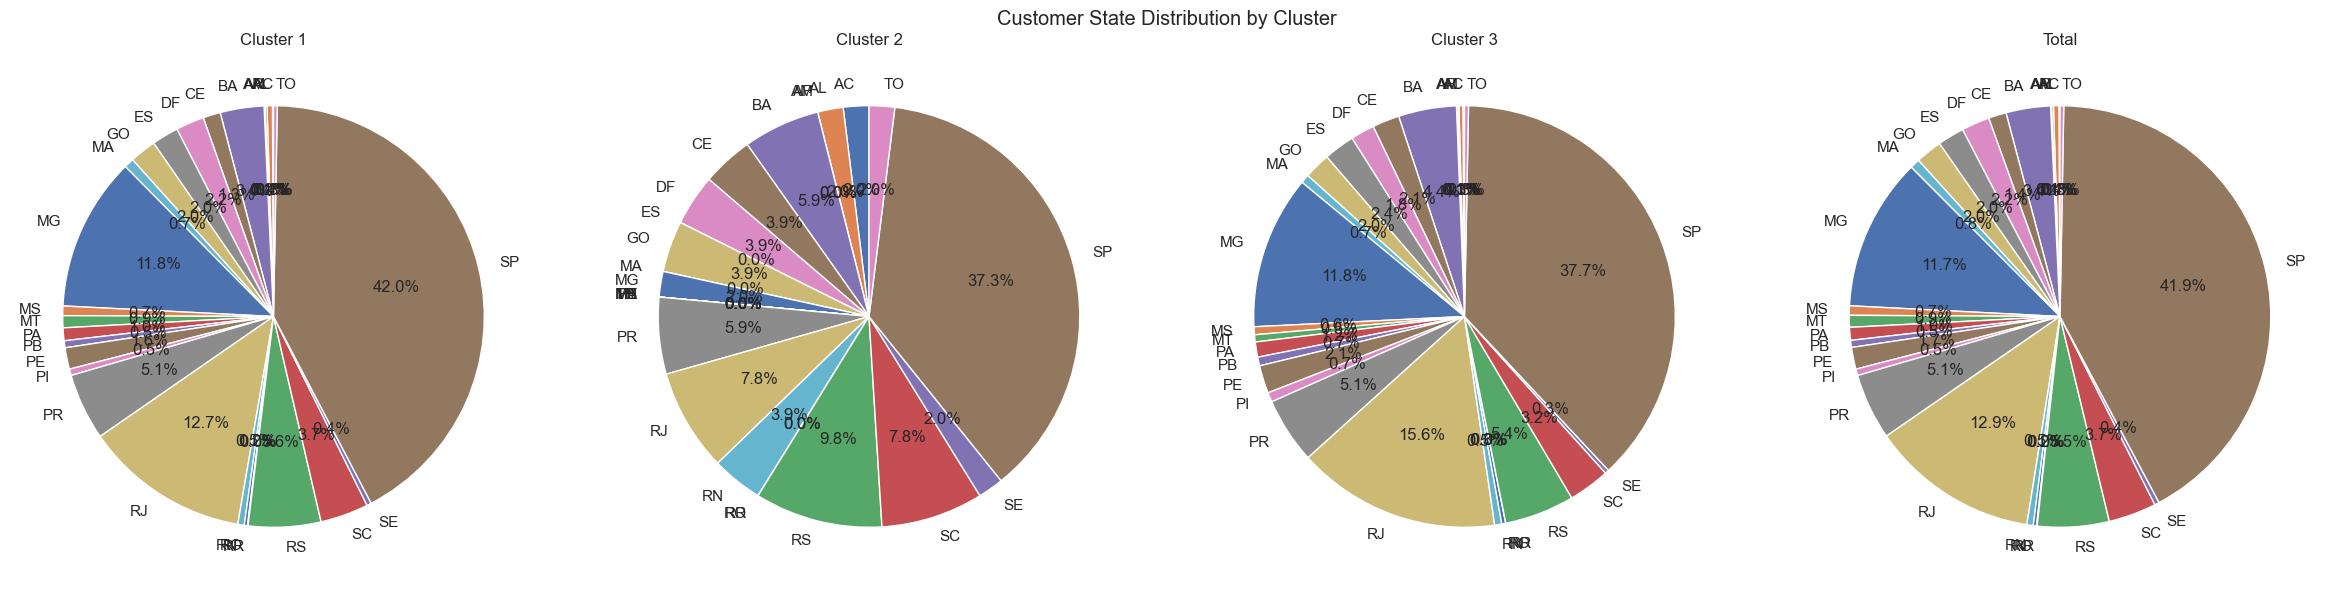

In [21]:
## pie chart about "customer_state" in each cluster
df_train = pd.read_csv('../datasets/df_train.csv')

def get_state_distribution(df):
    ## if NaN, fill with 'Unknown'
    return df['customer_state'].value_counts()

state_distribution = {
    'Cluster 1': get_state_distribution(df_cluster1),
    'Cluster 2': get_state_distribution(df_cluster2),
    'Cluster 3': get_state_distribution(df_cluster3),
    'Total': get_state_distribution(df_train)
}

df_state_distribution = pd.DataFrame(state_distribution).T
df_state_distribution.fillna(0, inplace=True)

# plot 3 pie chart for each cluster
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle('Customer State Distribution by Cluster')

for i, (cluster, data) in enumerate(df_state_distribution.iterrows()):
    ax = axes[i]
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(cluster)

plt.tight_layout()
plt.show()


In [22]:
df_customers = pd.read_csv('../datasets/olist_customers_dataset.csv')
df_order_payments = pd.read_csv("../datasets/olist_order_payments_dataset.csv")
df_orders = pd.read_csv('../datasets/olist_orders_dataset.csv')

payment_values = df_order_payments.groupby('order_id').payment_value.sum().reset_index()

df = pd.merge(
    df_customers[['customer_id', 'customer_unique_id', 'customer_state']],
    df_orders[['order_id', 'customer_id']],
    on='customer_id',
    how='inner'
)

df = pd.merge(
    df,
    payment_values,
    on='order_id',
    how='left'
)

print(df.isnull().sum())
df.fillna(0, inplace=True)
print(df.isnull().sum())

customer_id           0
customer_unique_id    0
customer_state        0
order_id              0
payment_value         1
dtype: int64
customer_id           0
customer_unique_id    0
customer_state        0
order_id              0
payment_value         0
dtype: int64


In [23]:
df.shape

(99441, 5)

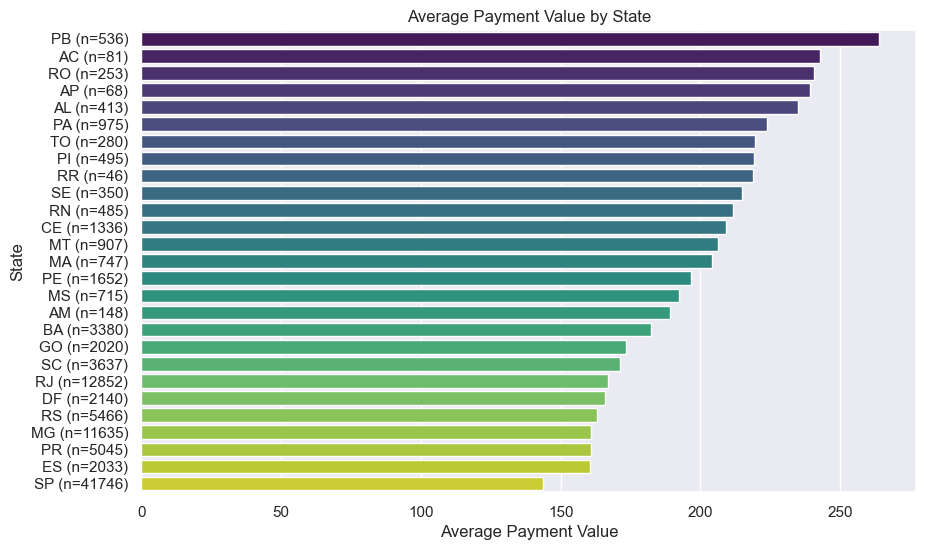

In [24]:
# Calculate the mean and count of payments by state
df_state_payment = df.groupby('customer_state')['payment_value'].agg(['mean', 'count']).reset_index()

# Modify the 'customer_state' to include the count
df_state_payment['customer_state'] = df_state_payment.apply(lambda x: f"{x['customer_state']} (n={x['count']})", axis=1)

# Sort the values by the average payment value in descending order
df_state_payment = df_state_payment.sort_values('mean', ascending=False)
df_state_payment.rename(columns={'mean': 'average_payment_value'}, inplace=True)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='average_payment_value', y='customer_state', data=df_state_payment, palette='viridis')

plt.title('Average Payment Value by State')
plt.xlabel('Average Payment Value')
plt.ylabel('State')
plt.show()
